## Reference: ##
1. https://keras.io/optimizers/
2. https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['embeddings', 'sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
import time
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import keras

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ",train_df.shape)
print("Test shape : ",test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [4]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

train_X = train_df["question_text"].values
val_X = val_df["question_text"].values
test_X = test_df["question_text"].values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values

In [5]:
def biGRU(optimizer):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [6]:
def find_threshold(model, val_X):
    pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)
    best_f1 = 0
    best_thresh = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        f1_score = metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))
        #print("F1 score at threshold {0} is {1}".format(thresh, f1_score))
        if f1_score > best_f1:
            best_f1 = f1_score
            best_thresh = thresh
    return best_f1, best_thresh

### Adam

In [7]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_adam = biGRU(adam)
print(model_adam.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total para

In [8]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [9]:
## Train the model 
adam_history = LossHistory()
model_adam.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[adam_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 234s 199us/step - loss: 0.1248 - acc: 0.9517 - val_loss: 0.1098 - val_acc: 0.9563
Epoch 2/2
1175509/1175509 [==============================] - 231s 196us/step - loss: 0.1000 - acc: 0.9600 - val_loss: 0.1074 - val_acc: 0.9573


In [10]:
best_adam_f1, best_thresh = find_threshold(model_adam, val_X)
print("Best F1 score {0} is at threshold {1}".format(best_adam_f1, best_thresh))

130613/130613 [==============================] - 6s 45us/step
Best F1 score 0.6554073395545887 is at threshold 0.3


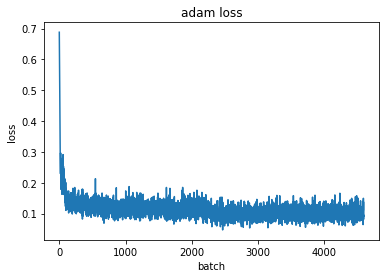

In [11]:
# summarize history for loss
plt.plot(adam_history.losses)
plt.title('adam loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [12]:
#pred_adam_test_y = model_adam.predict([test_X], batch_size=1024, verbose=1)

### SGD

In [13]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_sgd = biGRU(sgd)

In [14]:
sgd_history = LossHistory()
model_sgd.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[sgd_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 212s 180us/step - loss: 0.2246 - acc: 0.9376 - val_loss: 0.1930 - val_acc: 0.9378
Epoch 2/2
1175509/1175509 [==============================] - 211s 180us/step - loss: 0.1756 - acc: 0.9385 - val_loss: 0.1530 - val_acc: 0.9398


In [15]:
best_sgd_f1, best_thresh = find_threshold(model_sgd, val_X)
        
print("Best F1 score {0} is at threshold {1}".format(best_sgd_f1, best_thresh))

130613/130613 [==============================] - 6s 45us/step
Best F1 score 0.5030419468459814 is at threshold 0.19


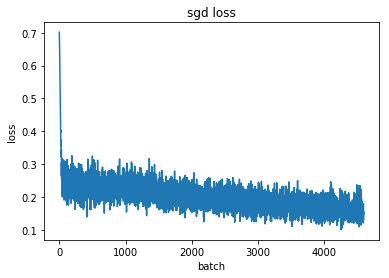

In [16]:
# summarize history for loss
plt.plot(sgd_history.losses)
plt.title('sgd loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [17]:
#pred_sgd_test_y = model_sgd.predict([test_X], batch_size=1024, verbose=1)

### RMSprop

In [18]:
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_rmsprop = biGRU(rmsprop)

In [19]:
rmsprop_history = LossHistory()
model_rmsprop.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[rmsprop_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 223s 189us/step - loss: 0.1244 - acc: 0.9531 - val_loss: 0.1135 - val_acc: 0.9553
Epoch 2/2
1175509/1175509 [==============================] - 222s 189us/step - loss: 0.1118 - acc: 0.9574 - val_loss: 0.1105 - val_acc: 0.9569


In [20]:
best_rms_f1, best_thresh = find_threshold(model_rmsprop, val_X)
print("Best F1 score {0} is at threshold {1}".format(best_rms_f1, best_thresh))

130613/130613 [==============================] - 6s 46us/step
Best F1 score 0.6456378986866792 is at threshold 0.32


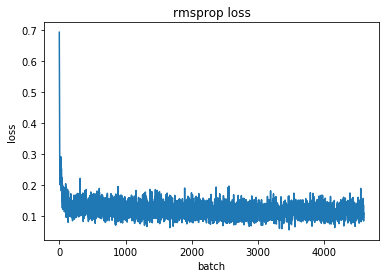

In [21]:
# summarize history for loss
plt.plot(rmsprop_history.losses)
plt.title('rmsprop loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [22]:
#pred_rmsprop_test_y = model_rmsprop.predict([test_X], batch_size=1024, verbose=1)

### Adagrad

In [23]:
adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
model_adagrad = biGRU(adagrad)

In [24]:
adagrad_history = LossHistory()
model_adagrad.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[adagrad_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 220s 187us/step - loss: 0.1179 - acc: 0.9536 - val_loss: 0.1077 - val_acc: 0.9562
Epoch 2/2
1175509/1175509 [==============================] - 218s 186us/step - loss: 0.0996 - acc: 0.9601 - val_loss: 0.1075 - val_acc: 0.9571


In [25]:
best_adagrad_f1, best_thresh = find_threshold(model_adagrad, val_X)
        
print("Best F1 score {0} is at threshold {1}".format(best_adagrad_f1, best_thresh))

130613/130613 [==============================] - 6s 46us/step
Best F1 score 0.6534502478078537 is at threshold 0.28


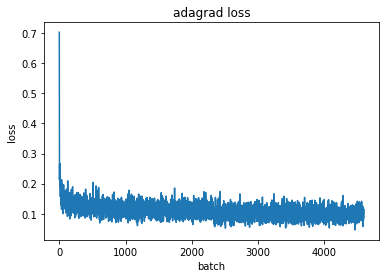

In [26]:
# summarize history for loss
plt.plot(adagrad_history.losses)
plt.title('adagrad loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [27]:
#pred_adagrad_test_y = model_adagrad.predict([test_X], batch_size=1024, verbose=1)

### Adadelta

In [28]:
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model_adadelta = biGRU(adadelta)

In [29]:
adadelta_history = LossHistory()
model_adadelta.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[adadelta_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 247s 210us/step - loss: 0.1436 - acc: 0.9485 - val_loss: 0.1171 - val_acc: 0.9531
Epoch 2/2
1175509/1175509 [==============================] - 244s 207us/step - loss: 0.1156 - acc: 0.9545 - val_loss: 0.1138 - val_acc: 0.9551


In [30]:
best_adadelta_f1, best_thresh = find_threshold(model_adadelta, val_X)
        
print("Best F1 score {0} is at threshold {1}".format(best_adadelta_f1, best_thresh))

130613/130613 [==============================] - 6s 46us/step
Best F1 score 0.6358058507724335 is at threshold 0.25


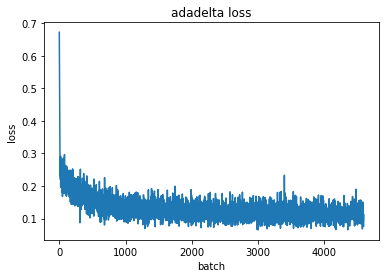

In [31]:
# summarize history for loss
plt.plot(adadelta_history.losses)
plt.title('adadelta loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [32]:
#pred_adadelta_test_y = model_adadelta.predict([test_X], batch_size=1024, verbose=1)

### Adamax

In [33]:
adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model_adamax = biGRU(adamax)

In [34]:
adamax_history = LossHistory()
model_adamax.fit(train_X, train_y, batch_size=512, epochs=2, validation_data=(val_X, val_y), callbacks=[adamax_history])

Train on 1175509 samples, validate on 130613 samples
Epoch 1/2
1175509/1175509 [==============================] - 225s 192us/step - loss: 0.1254 - acc: 0.9527 - val_loss: 0.1091 - val_acc: 0.9558
Epoch 2/2
1175509/1175509 [==============================] - 223s 190us/step - loss: 0.1041 - acc: 0.9582 - val_loss: 0.1059 - val_acc: 0.9569


In [35]:
best_adamax_f1, best_thresh = find_threshold(model_adamax, val_X)
        
print("Best F1 score {0} is at threshold {1}".format(best_adamax_f1, best_thresh))

130613/130613 [==============================] - 6s 47us/step
Best F1 score 0.6548878298268046 is at threshold 0.35


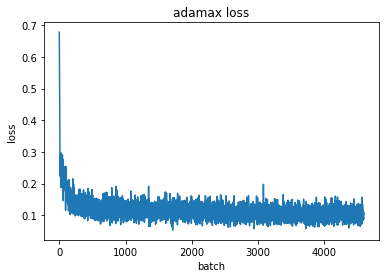

In [36]:
# summarize history for loss
plt.plot(adamax_history.losses)
plt.title('adamax loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.show()

In [37]:
#pred_adamax_test_y = model_adamax.predict([test_X], batch_size=1024, verbose=1)